In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import jaccard_score
import pandas as pd
import re

# PlantSeg imports
import plantseg
from plantseg.core.zoo import ModelZoo
from plantseg.tasks import import_image_task, unet_prediction_task

# CellPose imports
from cellpose import models, io

import napari

INFO: P [MainThread] 2025-01-24 17:24:48,829 plantseg - Logger configured at initialisation. PlantSeg logger name: plantseg


In [3]:
viewer = napari.Viewer()

In [4]:
# Helper function for loading images
def load_image(file_path):
    return cv2.imread(file_path, cv2.IMREAD_UNCHANGED)


# Function to perform segmentation using PlantSeg
def segment_with_plantseg(image_path, model_name="lightsheet_2D_unet_root_ds1x", patch=(1, 64, 64), device="cuda"):
    plantseg_image = import_image_task(input_path=Path(image_path), semantic_type="raw", stack_layout="ZYX")
    predicted_images = unet_prediction_task(image=plantseg_image, model_name=model_name, patch=patch, device=device)
    # Return the first predicted image
    return predicted_images[0].get_data()


# Function to perform segmentation using CellPose
def segment_with_cellpose(image_path, model_type="cyto2", flow_threshold=0.4, cellprob_threshold=0):
    image = io.imread(image_path)
    model = models.Cellpose(gpu=True, model_type=model_type)
    masks, flows, styles, diams = model.eval(image, diameter=None, channels=[0, 0], flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)
    return masks


# Function for calculating IoU with ground truth
def calculate_iou(pred, gt):
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    return jaccard_score(gt_flat, pred_flat, average="binary")


def get_images_for_masks(gt_gold_paths,image_paths):
    subset_paths = []
    for p in gt_gold_paths:
        first_gt_gold_file = os.path.basename(p)
        # Extract digits from the filename
        digits = int(re.findall(r"\d+", first_gt_gold_file)[0])
        subset_paths.append(image_paths[digits])
    return subset_paths




In [5]:
def process_datasets(base_path):
    results = []
    dataset_paths = glob.glob(os.path.join(base_path, "*"))  # Dataset-level directories (e.g., BF-C2DL-HSC)

    for dataset_path in dataset_paths:
        dataset_name = os.path.basename(dataset_path)
        # print(f"Processing dataset: {dataset_name}")

        all_dirs = sorted(glob.glob(os.path.join(dataset_path, "*/")))
        # print(f"  All directories in {dataset_name}: {all_dirs}")
        sequence_dirs = [d for d in all_dirs if os.path.isdir(d) and os.path.basename(os.path.dirname(d)).isdigit()]
        print(f"  Sequence directories in {dataset_name}: {sequence_dirs}")

        for sequence_dir in sequence_dirs:  # Sequences (e.g., 01, 02)
            sequence_name = os.path.basename(os.path.dirname(sequence_dir))
            print(f"  Processing sequence: {sequence_name}")

            images_dir = os.path.join(sequence_dir)
            err_seg_dir = os.path.join(dataset_path, f"{sequence_name}_ERR_SEG")
            st_dir = os.path.join(dataset_path, f"{sequence_name}_ST/SEG")
            gt_gold_dir = os.path.join(dataset_path, f"{sequence_name}_GT/SEG")

            # Collect image and ground-truth files
            image_files = sorted(glob.glob(os.path.join(images_dir, "*.tif")))
            gt_files = sorted(glob.glob(os.path.join(st_dir, "*.tif")))
            gt_gold_files = sorted(glob.glob(os.path.join(gt_gold_dir, "*.tif")))

            results.append({"dataset": dataset_name, "sequence": sequence_name, "image_path": image_files, "gt_path": gt_files, "gt_gold_path": gt_gold_files})

    return pd.DataFrame(results)



# Define paths and execute
base_path = "./datasets"  # Update this with the actual path to your datasets
results = process_datasets(base_path)

  Sequence directories in BF-C2DL-HSC: ['./datasets\\BF-C2DL-HSC\\01\\', './datasets\\BF-C2DL-HSC\\02\\']
  Processing sequence: 01
  Processing sequence: 02
  Sequence directories in BF-C2DL-MuSC: ['./datasets\\BF-C2DL-MuSC\\01\\', './datasets\\BF-C2DL-MuSC\\02\\']
  Processing sequence: 01
  Processing sequence: 02
  Sequence directories in DIC-C2DH-HeLa: ['./datasets\\DIC-C2DH-HeLa\\01\\', './datasets\\DIC-C2DH-HeLa\\02\\']
  Processing sequence: 01
  Processing sequence: 02
  Sequence directories in Fluo-C2DL-Huh7: ['./datasets\\Fluo-C2DL-Huh7\\01\\', './datasets\\Fluo-C2DL-Huh7\\02\\']
  Processing sequence: 01
  Processing sequence: 02
  Sequence directories in Fluo-C2DL-MSC: ['./datasets\\Fluo-C2DL-MSC\\01\\', './datasets\\Fluo-C2DL-MSC\\02\\']
  Processing sequence: 01
  Processing sequence: 02
  Sequence directories in Fluo-N2DH-GOWT1: ['./datasets\\Fluo-N2DH-GOWT1\\01\\', './datasets\\Fluo-N2DH-GOWT1\\02\\']
  Processing sequence: 01
  Processing sequence: 02
  Sequence direc

In [6]:
results

,dataset,sequence,image_path,gt_path,gt_gold_path
0,BF-C2DL-HSC,01,"[./datasets\BF-C2DL-HSC\01\t0000.tif, ./datase...",[./datasets\BF-C2DL-HSC\01_ST/SEG\man_seg0000....,[./datasets\BF-C2DL-HSC\01_GT/SEG\man_seg0058....
1,BF-C2DL-HSC,02,"[./datasets\BF-C2DL-HSC\02\t0000.tif, ./datase...",[./datasets\BF-C2DL-HSC\02_ST/SEG\man_seg0000....,[./datasets\BF-C2DL-HSC\02_GT/SEG\man_seg0046....
2,BF-C2DL-MuSC,01,"[./datasets\BF-C2DL-MuSC\01\t0000.tif, ./datas...",[./datasets\BF-C2DL-MuSC\01_ST/SEG\man_seg0000...,[./datasets\BF-C2DL-MuSC\01_GT/SEG\man_seg0061...
3,BF-C2DL-MuSC,02,"[./datasets\BF-C2DL-MuSC\02\t0000.tif, ./datas...",[./datasets\BF-C2DL-MuSC\02_ST/SEG\man_seg0000...,[./datasets\BF-C2DL-MuSC\02_GT/SEG\man_seg0007...
4,DIC-C2DH-HeLa,01,"[./datasets\DIC-C2DH-HeLa\01\t000.tif, ./datas...",[./datasets\DIC-C2DH-HeLa\01_ST/SEG\man_seg000...,[./datasets\DIC-C2DH-HeLa\01_GT/SEG\man_seg002...
5,DIC-C2DH-HeLa,02,"[./datasets\DIC-C2DH-HeLa\02\t000.tif, ./datas...",[./datasets\DIC-C2DH-HeLa\02_ST/SEG\man_seg000...,[./datasets\DIC-C2DH-HeLa\02_GT/SEG\man_seg006...
6,Fluo-C2DL-Huh7,01,"[./datasets\Fluo-C2DL-Huh7\01\t000.tif, ./data...",[],[./datasets\Fluo-C2DL-Huh7\01_GT/SEG\man_seg00...
7,Fluo-C2DL-Huh7,02,"[./datasets\Fluo-C2DL-Huh7\02\t000.tif, ./data...",[],[./datasets\Fluo-C2DL-Huh7\02_GT/SEG\man_seg00...
8,Fluo-C2DL-MSC,01,"[./datasets\Fluo-C2DL-MSC\01\t000.tif, ./datas...",[./datasets\Fluo-C2DL-MSC\01_ST/SEG\man_seg000...,[./datasets\Fluo-C2DL-MSC\01_GT/SEG\man_seg005...
9,Fluo-C2DL-MSC,02,"[./datasets\Fluo-C2DL-MSC\02\t000.tif, ./datas...",[./datasets\Fluo-C2DL-MSC\02_ST/SEG\man_seg000...,[./datasets\Fluo-C2DL-MSC\02_GT/SEG\man_seg000...


In [7]:

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("dataset_paths.csv", index=False)
print("Results saved to dataset_paths.csv")

Results saved to dataset_paths.csv


In [8]:
gt_paths = results_df.iloc[12]["gt_path"]
gt_gold_paths = results_df.iloc[12]["gt_gold_path"]
image_paths = results_df.iloc[12]["image_path"]


subset_image_paths = get_images_for_masks(gt_gold_paths, image_paths)

In [9]:
subset_image_paths

['./datasets\\Fluo-N2DH-SIM+\\01\\t000.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t001.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t002.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t003.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t004.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t005.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t006.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t007.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t008.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t009.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t010.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t011.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t012.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t013.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t014.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t015.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t016.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t017.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t018.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t019.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t020.tif',
 './datasets\\Fluo-N2DH-SIM+\\01\\t021.tif',
 './datase

In [10]:
from pathlib import Path
from plantseg.tasks import import_image_task, unet_prediction_task
from plantseg.core import PlantSegImage, ImageProperties, image
import cv2
from plantseg.core.zoo import ModelZoo
mz = ModelZoo(plantseg.PATH_MODEL_ZOO, plantseg.PATH_MODEL_ZOO_CUSTOM)


mz.get_model_names()


# input_path = Path(r"D:\toxo\Cole_002\Cole_002_TiffStack\002t01z04.tif")
# input_path = Path(r"C:\Users\Alireza Vaezi\Desktop\The Big Projects\TOXO PARENT\Toxo Data\stacked\Stack01.tif")

['generic_confocal_3D_unet',
 'generic_light_sheet_3D_unet',
 'confocal_3D_unet_ovules_ds1x',
 'confocal_3D_unet_ovules_ds2x',
 'confocal_3D_unet_ovules_ds3x',
 'confocal_2D_unet_ovules_ds2x',
 'lightsheet_3D_unet_root_ds1x',
 'lightsheet_3D_unet_root_ds2x',
 'lightsheet_3D_unet_root_ds3x',
 'lightsheet_2D_unet_root_ds1x',
 'lightsheet_3D_unet_root_nuclei_ds1x',
 'lightsheet_2D_unet_root_nuclei_ds1x',
 'confocal_2D_unet_sa_meristem_cells',
 'confocal_3D_unet_sa_meristem_cells',
 'lightsheet_3D_unet_mouse_embryo_cells',
 'confocal_3D_unet_mouse_embryo_nuclei',
 'PlantSeg_3Dnuc_platinum']

In [11]:
input_path = Path(os.path.abspath(subset_image_paths[10]))
input_path

WindowsPath('c:/Users/Alireza Vaezi/Desktop/The Big Projects/TOXO PARENT/TSEG/tseg/datasets/Fluo-N2DH-SIM+/01/t010.tif')

In [12]:
plantseg_image = import_image_task(input_path=input_path, semantic_type="raw", stack_layout="YX")  # Specify the semantic type: 'raw', 'segmentation', or 'prediction'  # Specify the stack layout: '3D', '2D', or '2D_time'

d:\miniforge3\envs\tseg\Lib\site-packages\plantseg\io\tiff.py:114: UserWarning: No metadata found.
  warnings.warn("No metadata found.")


INFO: P [MainThread] 2025-01-24 17:25:03,139 plantseg.functionals.prediction.prediction - Zoo prediction: Running model from PlantSeg official zoo.
INFO: P [MainThread] 2025-01-24 17:25:03,224 plantseg.functionals.prediction.prediction - Computing theoretical minimum halo from model.
INFO: P [MainThread] 2025-01-24 17:25:03,226 plantseg.functionals.prediction.prediction - For raw in shape (690, 628): set patch shape (1, 64, 64), set halo shape (0, 44, 44)
INFO: P [MainThread] 2025-01-24 17:25:03,862 plantseg.functionals.prediction.utils.array_predictor - Using batch size of 1 for prediction


100%|██████████| 195/195 [00:01<00:00, 157.21it/s]


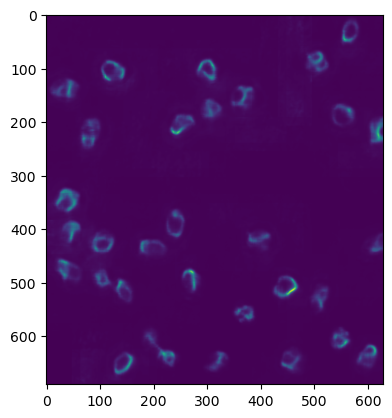

In [13]:
predicted_images = unet_prediction_task(image=plantseg_image, model_name="confocal_2D_unet_ovules_ds2x", model_id=None, suffix="_prediction", patch=(1, 64, 64), device="cuda")  # Replace with the name of the model you wish to use  # Replace with the ID of the model you wish to use  # Suffix to append to the new image name  # Patch size for prediction; adjust as needed  # Specify 'cuda' for GPU or 'cpu' for CPU

plt.imshow(predicted_images[0].get_data())

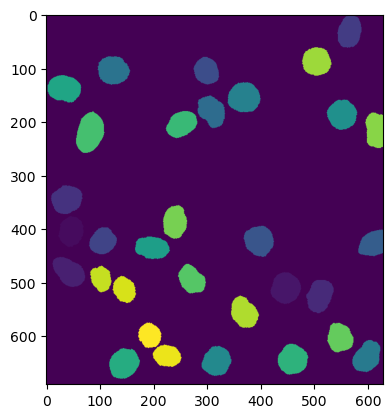

In [14]:
gt_mask = cv2.imread(gt_gold_paths[10], cv2.IMREAD_UNCHANGED)
plt.imshow(gt_mask)

In [24]:
from cellpose import models, utils, io
import matplotlib.pyplot as plt

# Load the image
image_path = subset_image_paths[10]  # Replace with the path to your image
image = io.imread(image_path)

import cellpose.models


# Initialize a Cellpose model
model = models.CellposeModel(True, model_type="CPx")  # Use 'cyto' for cytoplasm, 'nuclei' for nuclei segmentation

In [22]:
cellpose.models.MODEL_NAMES

['cyto3',
 'nuclei',
 'cyto2_cp3',
 'tissuenet_cp3',
 'livecell_cp3',
 'yeast_PhC_cp3',
 'yeast_BF_cp3',
 'bact_phase_cp3',
 'bact_fluor_cp3',
 'deepbacs_cp3',
 'cyto2',
 'cyto',
 'CPx',
 'transformer_cp3',
 'neurips_cellpose_default',
 'neurips_cellpose_transformer',
 'neurips_grayscale_cyto2',
 'CP',
 'CPx',
 'TN1',
 'TN2',
 'TN3',
 'LC1',
 'LC2',
 'LC3',
 'LC4']

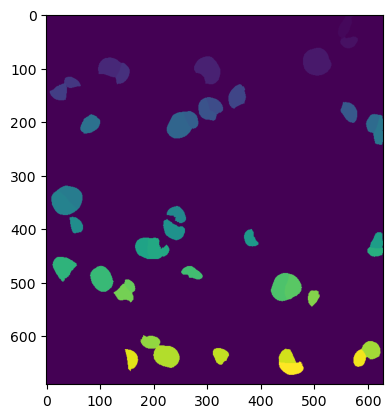

In [23]:
# Run the segmentation model
masks, flows, styles = model.eval(image, diameter=None, channels=[0, 0], flow_threshold=0.4, cellprob_threshold=0)  # Set None to let the model estimate the object size  # Grayscale: [0, 0]; for RGB, use [0, 1] (e.g., nuclear and cytoplasm)  # Adjust this parameter as needed  # Adjust this parameter as needed
plt.imshow(masks)